In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
from eofs.xarray import Eof
import tensorflow as tf
import gpflow
from esem import gp_model
import seaborn as sns
import cartopy.crs as ccrs
from utils import *

### Prepare data

In [11]:
# List of dataset to use for training
train_files = ["ssp126", "ssp585", "historical", "hist-GHG"]

In [12]:
# Create training and testing arrays
X_train, eof_solvers = create_predictor_data(train_files)
y_train_tas = create_predictdand_data(train_files)['tas'].values.reshape(-1, 96 * 144)

X_test = get_test_data('ssp245', eof_solvers)
Y_test = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()
tas_truth = Y_test["tas"].mean('member')

In [13]:
# Drop rows including nans
nan_train_mask = X_train.isna().any(axis=1).values
X_train = X_train.dropna(axis=0, how='any')
y_train_tas = y_train_tas[~nan_train_mask]
assert len(X_train) == len(y_train_tas)

nan_test_mask = X_test.isna().any(axis=1).values
X_test = X_test.dropna(axis=0, how='any')
tas_truth = tas_truth[~nan_test_mask]

In [14]:
# Standardize predictor fields requiring standardization (non-EOFs)
train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()

X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std

X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std

In [15]:
# Standardize predictand fields
train_tas_mean, train_tas_std = y_train_tas.mean(), y_train_tas.std()
y_train_tas = (y_train_tas - train_tas_mean) / train_tas_std

### Prepare model

In [16]:
# Make kernel
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

In [17]:
# Make model
np.random.seed(5)
mean = gpflow.mean_functions.Constant()
model = gpflow.models.GPR(data=(X_train.astype(np.float64), 
                                y_train_tas.astype(np.float64)),
                          kernel=kernel,
                          mean_function=mean)

In [18]:
# Define optimizer
opt = gpflow.optimizers.Scipy()

# Train model
opt.minimize(model.training_loss,
             variables=model.trainable_variables,
             options=dict(disp=True, maxiter=1000))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.36168D+06    |proj g|=  1.11308D+06


 This problem is unconstrained.



At iterate    1    f=  2.62406D+06    |proj g|=  4.17188D+05

At iterate    2    f=  2.47178D+06    |proj g|=  1.40369D+05

At iterate    3    f=  2.35788D+06    |proj g|=  1.93973D+05

At iterate    4    f=  1.84966D+06    |proj g|=  3.45817D+04

At iterate    5    f=  1.78789D+06    |proj g|=  2.10418D+04

At iterate    6    f=  1.74295D+06    |proj g|=  1.69679D+04

At iterate    7    f=  1.73044D+06    |proj g|=  2.16957D+04

At iterate    8    f=  1.72721D+06    |proj g|=  4.11995D+03

At iterate    9    f=  1.72600D+06    |proj g|=  4.67544D+03

At iterate   10    f=  1.72283D+06    |proj g|=  5.78548D+03

At iterate   11    f=  1.71979D+06    |proj g|=  3.81703D+03

At iterate   12    f=  1.71903D+06    |proj g|=  2.88022D+03

At iterate   13    f=  1.71561D+06    |proj g|=  2.08363D+04

At iterate   14    f=  1.71480D+06    |proj g|=  1.29871D+04

At iterate   15    f=  1.71410D+06    |proj g|=  3.02139D+03

At iterate   16    f=  1.71372D+06    |proj g|=  5.46697D+03

At iter

      fun: 1673518.861890582
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>
      jac: array([   7.94828053,    0.88411978,   -1.82798839,   -3.00622457,
          6.7224249 ,   22.16134805,    0.79080538,    4.23172587,
        -33.38948613,  -55.85499809,    1.11598157,    9.389602  ,
          0.35612409,   -1.27714275,   -0.79765691,    0.79000786,
       -113.92163021,   -1.53587763])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 580
      nit: 492
     njev: 580
   status: 0
  success: True
        x: array([ 7.75375163,  6.52965288,  2.89624567, -3.61196591,  7.40149991,
       -2.39977384, 24.26124372,  0.95238199, -2.06283346, -3.584068  ,
        5.85985827,  8.54399437, 22.74806335, 72.99446399, 60.80955938,
       -1.56001754, -2.38657125,  0.56374991])

At iterate  492    f=  1.67352D+06    |proj g|=  1.13922D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18    492    580      1     0     0   1.139D+02   1.674D+06
  F =   1673518.8618905819     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


### Predict on testing set

In [19]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
posterior_mean = standard_posterior_mean * train_tas_std + train_tas_mean
posterior_std = np.sqrt(standard_posterior_var) * train_tas_std

In [20]:
# put output back into xarray format for calculating RMSE/plotting
posterior_tas = np.reshape(posterior_mean, [86, 96, 144])
posterior_tas_std = np.reshape(posterior_std, [86, 96, 144])

posterior_tas_data = xr.DataArray(posterior_tas, dims=tas_truth.dims, coords=tas_truth.coords)
posterior_tas_std_data = xr.DataArray(posterior_tas_std, dims=tas_truth.dims, coords=tas_truth.coords)

In [21]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(tas_truth[35], posterior_tas_data[35])}")
print(f"RMSE at 2100: {get_rmse(tas_truth[85], posterior_tas_data[85])}")
print(f"RMSE 2045-2055: {get_rmse(tas_truth[30:41], posterior_tas_data[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(tas_truth[75:], posterior_tas_data[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(tas_truth[35:], posterior_tas_data[35:]).mean()}")

RMSE at 2050: 0.30269855197032286
RMSE at 2100: 0.32546134509720726
RMSE 2045-2055: 0.3375405231471907
RMSE 2090-2100: 0.35627190476294557
RMSE 2050-2100: 0.35962442551134655


[Text(0.5, 1.0, 'Difference')]

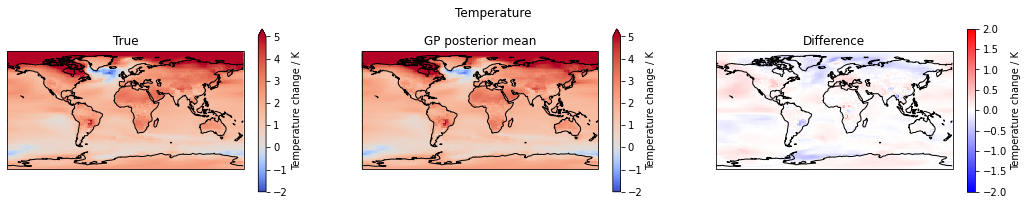

In [22]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Temperature')

# Test
plt.subplot(131, projection=proj)
tas_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
posterior_tas_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = tas_truth - posterior_tas_data
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

__Feature importance__
- Mostly CO2
- Really just CO2
- Small noise variance

In [23]:
model

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,"(1,)",float64,[0.56374991]
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,6.531111323615465
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,7.754180665798048
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.02664068230769058
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,2.950004594427679
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.027384138710425422
GPR.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[7.40211006, 0.08685496, 24.26124372..."
GPR.kernel.kernels[3].variance,Parameter,Softplus,,True,(),float64,0.1907297629435237
GPR.kernel.kernels[3].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[5.86270586, 8.54418906, 22.74806335..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.08796095870488162


In [ ]:
# Save predictions
posterior_tas_data.to_netcdf('climatebench-gp-posterior-mean-tas-test-2019-2100.nc')
posterior_tas_std_data.to_netcdf('climatebench-gp-posterior-std-tas-test-2019-2100.nc')